# 用道路切分地块！shapely的线转面处理
用路网和行政区划数据生成地块矢量

## 读取数据

<AxesSubplot:>

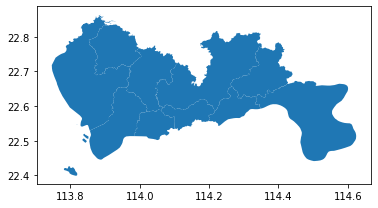

In [2]:
#导入必要的包
import pandas as pd
import numpy as np

#绘制图用的包
import matplotlib as mpl
import matplotlib.pyplot as plt

#geopandas包
import geopandas

#shapely包
from shapely.geometry import Point,Polygon,shape

#读取shapefile文件
shp = '/home/liu/Documents/pygeo-tutorial/shapefile/sz.shp'
sz = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')

#绘制看看长什么样
sz.plot()

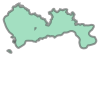

In [3]:
sz = sz.unary_union
sz

<AxesSubplot:>

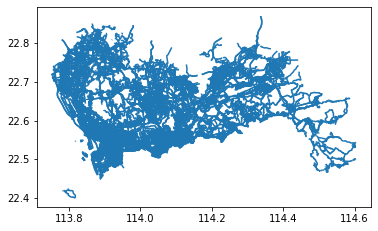

In [4]:
#路网
shp = r'/home/liu/Documents/pygeo-tutorial/shapefile/shenzhen_osmroad.shp'
road = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')

#绘制看看长什么样
road.plot()

## 开始
首先我们将路网的线和行政区划的面的边界组合到一起

<AxesSubplot:>

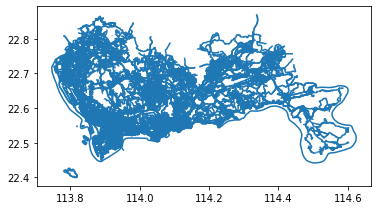

In [5]:
lines = list(road['geometry'])+list(sz.boundary)
geopandas.GeoDataFrame({'geometry':lines}).plot()

In [6]:
import shapely
#第一个操作：把相邻的线合成到一起，即A的起点和B终点在同一个位置，那么把AB合成一起（如果不这样做，后面得到的结果可能会在AB端点处打断，但AB端点不一定是交点）
merged_lines = shapely.ops.linemerge(lines)
#第二个操作：合并为整体，但是实际上是线段的组合，会在交点处打断
border_lines = shapely.ops.unary_union(merged_lines)
#上面两个操作连起来实现的功能就是在交点处打断线
#第三个操作：生成线段所组成的面
decomposition = shapely.ops.polygonize_full(border_lines)

In [7]:
decomposition

(<shapely.geometry.collection.GeometryCollection at 0x7f1e86704290>,
 <shapely.geometry.collection.GeometryCollection at 0x7f1e85dbd3d0>)

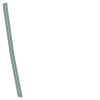

In [8]:
decomposition[0][0]

In [9]:
area = geopandas.GeoDataFrame({'geometry':list(decomposition[0])})

In [10]:
area1 = area.buffer(-0.00015)
#经纬度的1°大约等于111.111km，也就是说
#这里设定的0.00015大约是
#0.00015*1000*111.111 = 16.66665m

#接下来把buffer一下就没了的面删除
area1 = area1[-area1.is_empty]

#生成一个新的gdf
area1 = geopandas.GeoDataFrame({'geometry':area1})

<AxesSubplot:>

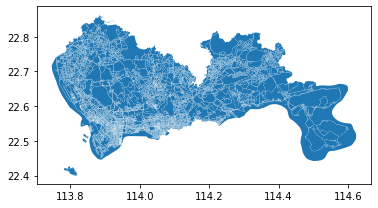

In [11]:
area1.plot()

提取每个地块的中心点

<AxesSubplot:>

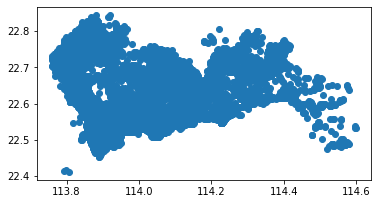

In [12]:
areacentroid = area1.copy()
areacentroid['geometry'] = area1.centroid
areacentroid.plot()

imgsavepath do not exist, your tile map will not save


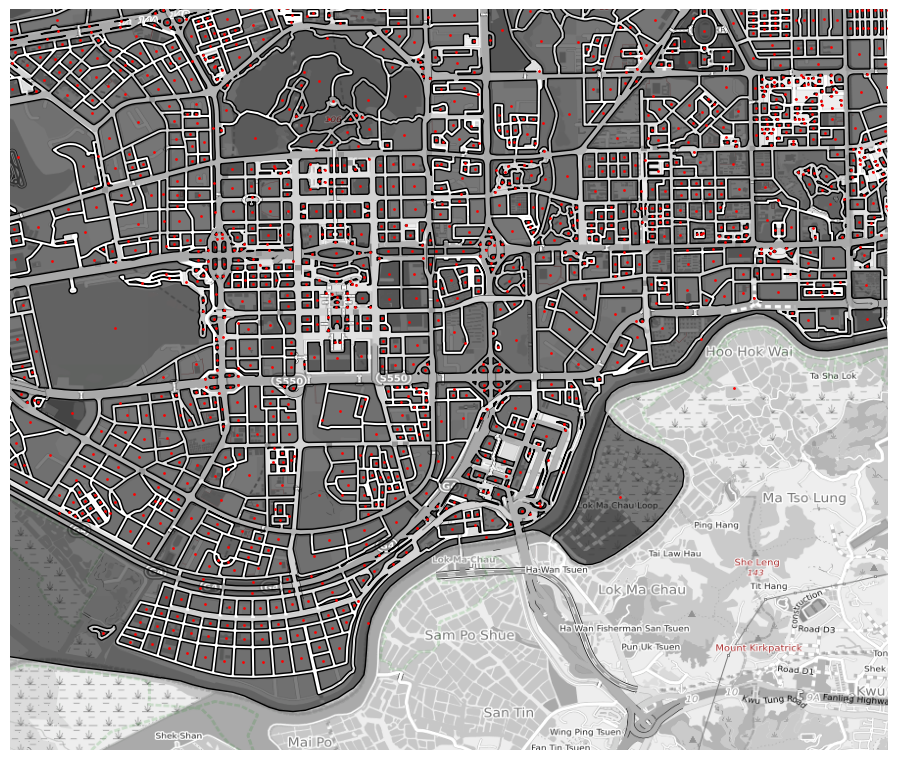

In [13]:
#放大看看
lat1sh = 22.499;
lat2sh = 22.564;
lon1sh = 114.026;
lon2sh = 114.103;
bounds = [lon1sh,lat1sh,lon2sh,lat2sh]

import matplotlib as mpl
import matplotlib.pyplot as plt
import plot_map
import seaborn as sns
fig     = plt.figure(1,(10,10),dpi = 100)      
ax      = plt.subplot(111)
plt.sca(ax)
fig.tight_layout(rect = (0.05,0.1,1,0.9))

#背景
plot_map.plot_map(plt,bounds,zoom = 14,style = 4)

#绘制地块
area1.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0.5))
#绘制地块中心点
areacentroid.plot(ax = ax,markersize = 1,color = 'red')


plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])

plt.show()